In [1]:
import pandas as pd
from sdv.single_table import GaussianCopulaSynthesizer

real_data = pd.read_csv("dataset_1.csv")

from sdv.metadata import SingleTableMetadata 

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data=real_data)
synthetic_data = synthesizer.sample(num_rows=300)

synthetic_data.to_csv('synthetic_data.csv', index=False)


/home/codespace/.python/current/lib/python3.12/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/codespace/.python/current/lib/python3.12/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [2]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 20/20 [00:00<00:00, 751.85it/s]|
Column Shapes Score: 91.76%

(2/2) Evaluating Column Pair Trends: |██████████| 190/190 [00:00<00:00, 216.92it/s]|
Column Pair Trends Score: 88.75%

Overall Score (Average): 90.25%



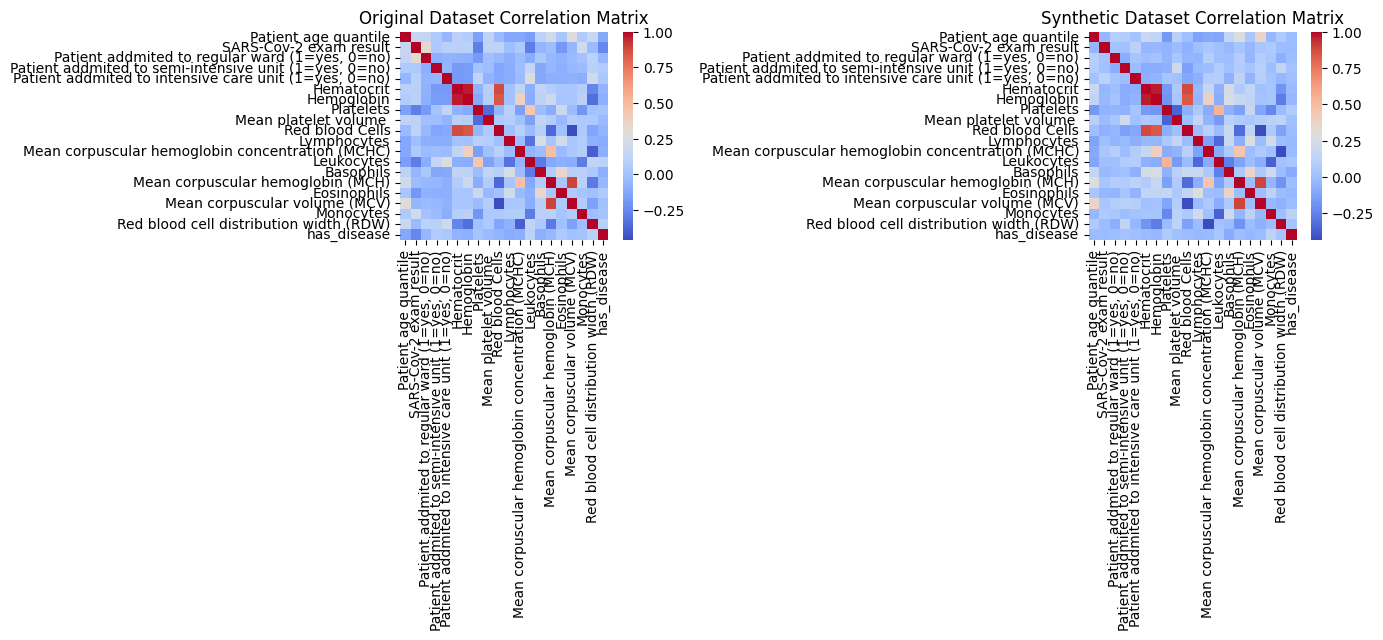

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

original_corr = real_data.corr()
synthetic_corr = synthetic_data.corr()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(original_corr, annot=False, cmap="coolwarm", cbar=True, square=True)
plt.title("Original Dataset Correlation Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=False, cmap="coolwarm", cbar=True, square=True)
plt.title("Synthetic Dataset Correlation Matrix")

plt.tight_layout()
plt.show()

In [4]:
from scipy.stats import ks_2samp, chi2_contingency
import seaborn as sns

# --- Validation: Kolmogorov-Smirnov (K-S) Test for Continuous Features ---
ks_test_results = {}
chi_square_results = {}

for column in real_data.columns:
    unique_values = real_data[column].nunique()

    if unique_values <= 2: 
        observed = synthetic_data[column].round().value_counts().sort_index()
        expected = real_data[column].round().value_counts().sort_index()

        # Align indices in case categories differ
        all_categories = set(observed.index).union(set(expected.index))
        observed = observed.reindex(all_categories, fill_value=0)
        expected = expected.reindex(all_categories, fill_value=0)

        chi2, p_value, _, _ = chi2_contingency([observed, expected])
        chi_square_results[column] = {"Chi2": chi2, "P-Value": p_value}
    
    else:
        ks_statistic, p_value = ks_2samp(real_data[column], synthetic_data[column])
        ks_test_results[column] = {"KS Statistic": ks_statistic, "P-Value": p_value}

# Display K-S Test results for continuous features
ks_test_df = pd.DataFrame(ks_test_results).T
print("\nKolmogorov-Smirnov Test Results for Continuous Features:")
print(ks_test_df)

# Display Chi-Square Test results for discrete features
chi_square_results_df = pd.DataFrame(chi_square_results).T
print("\nChi-Square Test Results for Discrete Features:")
print(chi_square_results_df)


Kolmogorov-Smirnov Test Results for Continuous Features:
                                                  KS Statistic       P-Value
Patient age quantile                                  0.072658  2.257605e-01
Hematocrit                                            0.066423  3.207067e-01
Hemoglobin                                            0.082270  1.239063e-01
Platelets                                             0.052270  6.203751e-01
Mean platelet volume                                  0.065670  3.348746e-01
Red blood Cells                                       0.078826  1.553846e-01
Lymphocytes                                           0.104684  2.266362e-02
Mean corpuscular hemoglobin concentration (MCHC)      0.071085  2.472286e-01
Leukocytes                                            0.086390  9.333210e-02
Basophils                                             0.419114  5.077574e-32
Mean corpuscular hemoglobin (MCH)                     0.070354  2.596711e-01
Eosinophils       

In [5]:
from sdv.evaluation.single_table import get_column_plot

for column in real_data.columns:
    fig = get_column_plot(
        real_data=real_data,
        synthetic_data=synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()

In [12]:
merged_data = pd.concat([real_data, synthetic_data], ignore_index=True)
merged_data = merged_data.sample(frac=1, random_state=42).reset_index(drop=True)

merged_data

merged_data.to_csv("final_data.csv", index=False)